In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Hyperparameters and Configuration
BATCH_SIZE = 60000  # Full batch training for MNIST (60,000 samples)
LEARNING_RATE = 1.0  # LBFGS doesn't use a typical learning rate in the same way as SGD, 
                     # but a small value can sometimes help with initial line search.
                     # Often, the default is fine or you might adjust history size.
LOG_INTERVAL = 10   # How often to print training progress

# 2. Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),         # Convert images to PyTorch Tensors
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize pixel values
])

# Download and load the MNIST training dataset
train_dataset = datasets.MNIST('../data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST('../data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False) # Use a smaller batch for testing

# 3. Model Definition (Logistic Regression)
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # Flatten image
        outputs = self.linear(x)
        return outputs
    
# Instantiate the model
input_dim = 28 * 28  # MNIST image size
output_dim = 10      # 10 classes (digits 0-9)
model = LogisticRegression(input_dim, output_dim)

In [ ]:
# 4. Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(model.parameters(), 
                        lr=LEARNING_RATE, 
                        max_iter=20, 
                        history_size=100,
                        )
# - lr: Learning rate. Can be set to a small value or left at default.
# - max_iter: Maximum number of function evaluations per optimization step. 
#             This is important for LBFGS. A larger value means more internal iterations.
# - history_size: Size of the history for the L-BFGS approximation.

# 5. Training Function
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        #A closure that reevaluates the model and returns the loss.
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            return loss
        
        loss = optimizer.step(closure)

        print(f'Train Batch: {batch_idx} \tLoss: {loss.item():.6f}')
        # Original corrected line:
        optimizer.step(closure)
        if batch_idx % LOG_INTERVAL == 1: # Only one batch in full batch training, so this fires once
            print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')

# 6. Testing Function
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [5]:
NUM_EPOCHS = 10    # Number of optimization steps for LBFGS (it's not epochs in the SGD sense)

print(f"Training Logistic Regression with LBFGS on MNIST...")
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train(epoch)
    # test()

print("Training finished.")

Training Logistic Regression with LBFGS on MNIST...
Epoch 1/10
Train Batch: 0 	Loss: 2.424816
Epoch 2/10
Train Batch: 0 	Loss: 0.252782
Epoch 3/10
Train Batch: 0 	Loss: 0.224859
Epoch 4/10
Train Batch: 0 	Loss: 0.216352
Epoch 5/10
Train Batch: 0 	Loss: 0.213280
Epoch 6/10
Train Batch: 0 	Loss: 0.210434
Epoch 7/10
Train Batch: 0 	Loss: 0.208851
Epoch 8/10
Train Batch: 0 	Loss: 0.207568
Epoch 9/10
Train Batch: 0 	Loss: 0.206436
Epoch 10/10
Train Batch: 0 	Loss: 0.205806
Training finished.


### Backup

In [5]:
import torch, json
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 60000  

transform = transforms.Compose([
    transforms.ToTensor(),        
    transforms.Normalize((0.1307,), (0.3081,)) 
])
train_dataset = datasets.MNIST('../data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.MNIST('../data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False) 

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 28 * 28) 
        outputs = self.linear(x)
        return outputs
    
input_dim = 28 * 28  
output_dim = 10
model = LogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(model.parameters(), 
                        max_iter=20, 
                        history_size=100,
                        )

# from c_lbfgs import LBFGS
# optimizer = LBFGS(model.parameters(), history_size=100)


def train(n_epochs, eval=False):
    model.train()
    train_losses = {}
    test_losses = {}
    for epoch in range(n_epochs):
        train_losses[epoch] = 0.0
        for data, target in train_loader:
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss

            # def closure():
            #     for p in model.parameters():
            #         if p.grad is not None:
            #             p.grad.zero_()
            #     output = model(data)
            #     loss = criterion(output, target)
            #     loss.backward()
            #     return loss
    
            loss = optimizer.step(closure) 
            optimizer.step(closure)
            train_losses[epoch] += loss.item()

            if eval:
                model.eval()
                test_losses[epoch] = 0.0
                correct = 0
                with torch.no_grad():
                    for data, target in test_loader:
                        output = model(data)
                        test_losses[epoch] += criterion(output, target).item()
                        pred = output.argmax(dim=1, keepdim=True)
                        correct += pred.eq(target.view_as(pred)).sum().item()
                test_losses[epoch] /= len(test_loader.dataset)
                
    with open('./metrics/train_lbfgs_loss.json', 'w') as f:
        json.dump(train_losses, f)
    with open('./metrics/test_lbfgs_loss.json', 'w') as f:
        json.dump(test_losses, f)

NUM_EPOCHS = 5
train(n_epochs=NUM_EPOCHS, eval=True)

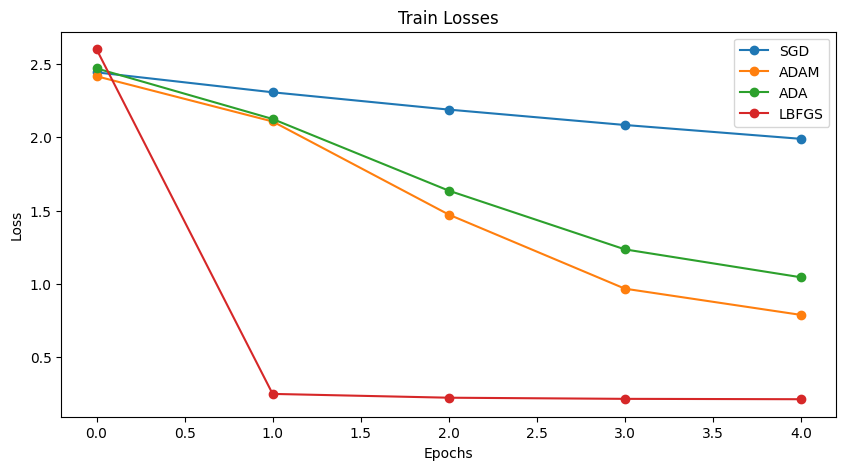

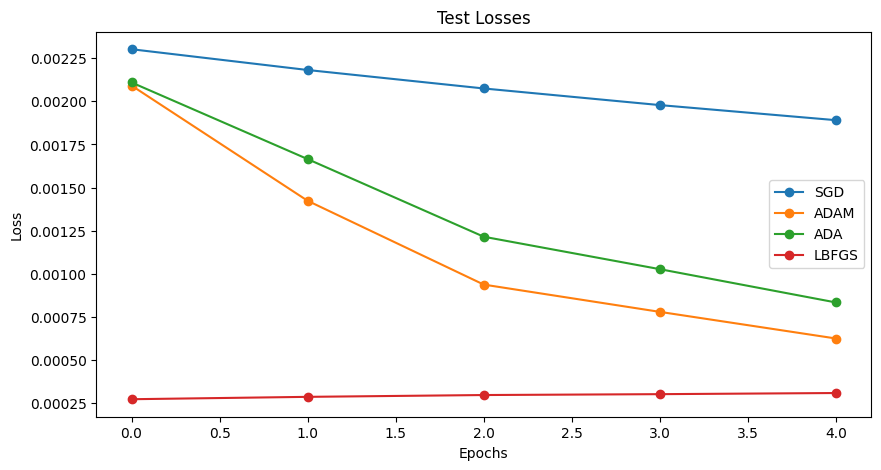

In [6]:
import matplotlib.pyplot as plt
train_losses_dict = {}
test_losses_dict = {}

for opt in ['sgd', 'adam', 'ada', 'lbfgs']:
    with open(f'./metrics/train_{opt}_loss.json', 'r') as f:
        train_losses_dict[opt] = json.load(f)
    with open(f'./metrics/test_{opt}_loss.json', 'r') as f:
        test_losses_dict[opt] = json.load(f)

def plot_losses(losses_dict, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    for opt, losses in losses_dict.items():
        epochs = list(map(int, losses.keys()))
        loss_values = list(losses.values())
        plt.plot(epochs, loss_values, marker='o', label=f'{opt.upper()}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_losses(train_losses_dict, 'Train Losses', 'Epochs', 'Loss')
plot_losses(test_losses_dict, 'Test Losses', 'Epochs', 'Loss')
